# Test
*3 May 2024*

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

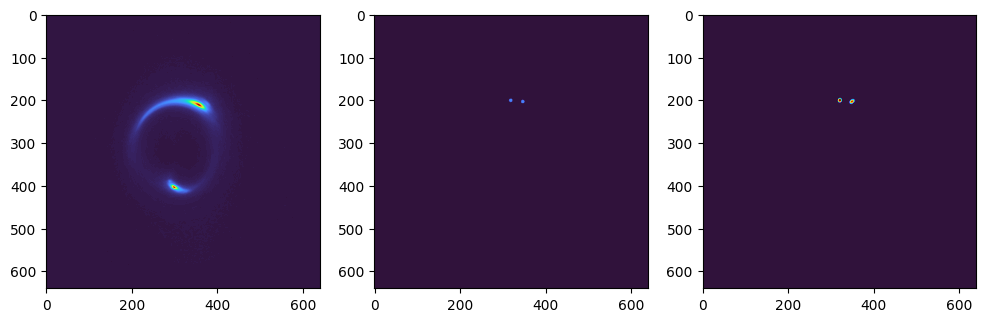

In [29]:
i = 1010000 + 3
path = '/n/holyscratch01/dvorkin_lab/Users/atsang/mif/{}_catval_exp10_c60_br20_nsub2_hstelt3/' f'{i}.npy'
myin = np.load(path.format('in'))
mycoord = np.load(path.format('coord'))
myout = np.load(path.format('stdout'))
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(myin, 'turbo')
ax[1].imshow(mycoord, 'turbo', vmin=0, vmax=6)
ax[2].imshow(myout[1], 'turbo', vmin=0, vmax=1)

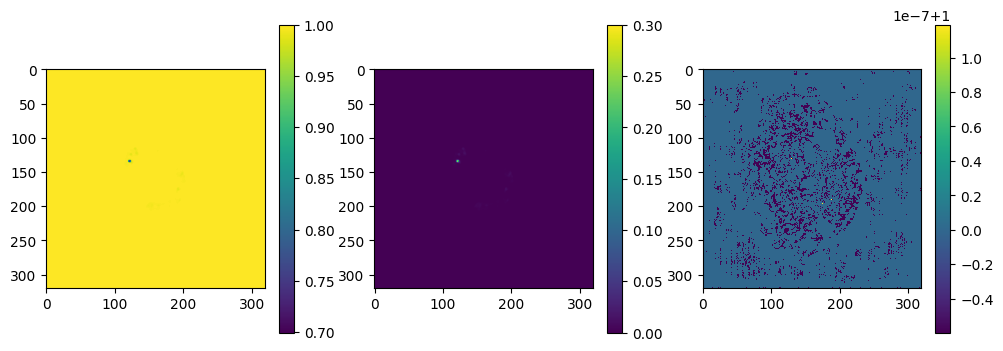

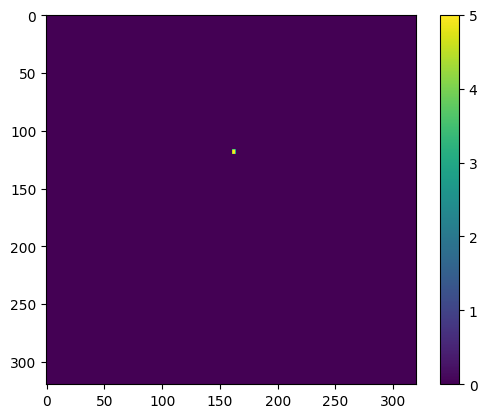

In [11]:
i = 1010007
path =f'/n/holyscratch01/dvorkin_lab/Users/atsang/mif/stdout_catval_exp10_c60_br5_nsub1_hstelt/{i}.npy'

myarr = np.load(path)

myarr.shape

fig, ax = plt.subplots(1, 3, figsize=(12,4))
cbar0 = ax[0].imshow(myarr[0])#, vmin=0, vmax=1)
cbar1 = ax[1].imshow(myarr[1])#, vmin=0, vmax=1)
cbar2 = ax[2].imshow(myarr[0] + myarr[1])

plt.colorbar(cbar0, ax=ax[0])
plt.colorbar(cbar1, ax=ax[1])
plt.colorbar(cbar2, ax=ax[2])

plt.show()

coord_path = f'/n/holyscratch01/dvorkin_lab/Users/atsang/mif/coord_catval_exp10_c60_br5_nsub1_hstelt/{i}.npy'

coord_arr = np.load(coord_path)
plt.imshow(coord_arr)
plt.colorbar()

In [6]:
from data_gen_bright import gen_image_general

/n/home13/atsang/.local/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


In [68]:
noisy, blank_noisy, coord, macro = gen_image_general(0, True, [1e11, 1e11], 'cattrain', mode='regular', cat_source=True,
                                                     pixnum=640, pixsize=.01, n_subhalo=2, pixrad=2)

In [69]:
macro

{'z': [0.5, 0.5],
 'mass_multiplier': array([0.34959455, 0.32367503]),
 'main_theta': 1.0195254015709299,
 'gamma': 2.2151893663724196,
 'phi_lens': 0.32284066732476147,
 'q_lens': 0.7724415914984484,
 'center_lens_x': -0.030538080264438106,
 'center_lens_y': 0.058357645226662425,
 'shear1': -0.0124825577474615,
 'shear2': 0.07835460015641596,
 'lens_a3': 0.018546510420041174,
 'lens_phi3': -0.24411951211368066,
 'lens_a4': 0.01166900152330658,
 'lens_phi4': 0.04538803381089562,
 'source_phi': -2.695259936440876,
 'source_center_x': 0.027217824437572924,
 'source_center_y': 0.17023865531706445,
 'mass_sheets': True,
 'zl': 0.5,
 'zs': 1.0,
 'pixnum': 640,
 'pixsize': 0.01,
 'rs': 0.0001,
 'use_val_cat': False,
 'observation_config': telescopes.HSTELT3,
 'observation_band': 'my_filter',
 'observation_psf_type': 'GAUSSIAN'}

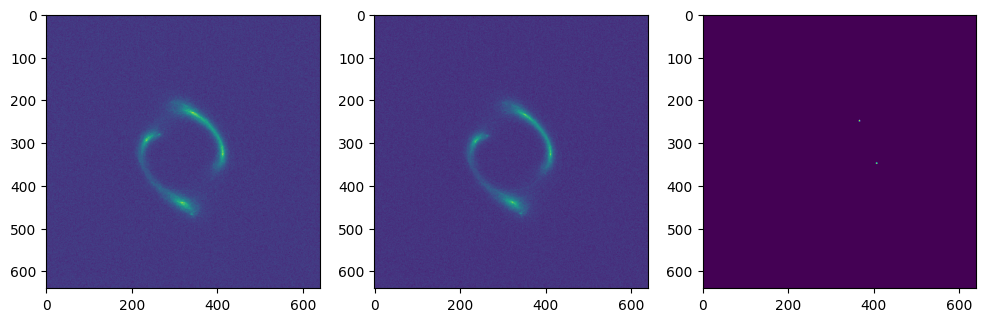

In [70]:
fig, ax = plt.subplots(1,3,figsize=(12,4))
ax[0].imshow(noisy)
ax[1].imshow(blank_noisy)
ax[2].imshow(coord)

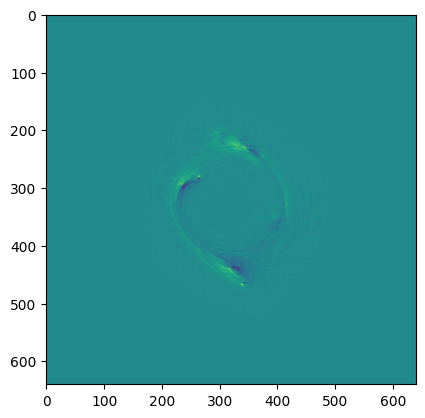

In [71]:
plt.imshow(noisy - blank_noisy)

Great, now let's try loading the neural net and see what happens

In [72]:
import torch
from SegmentationUtilities import translate_dict
from bl_bigkerunet import model_generator_generator as bigker_gg
#from scipy.special import softmax

In [73]:
!ls -lht Models | head -n 20

total 35M
-rw-r--r--. 1 atsang dvorkin_lab 5.7M Oct 28  2023 chk_bigkerUNet_5e5data7.tar
-rw-r--r--. 1 atsang dvorkin_lab  23M Oct 28  2023 bigkerUNet_5e5data7.tar


In [74]:
mname = 'bigkerUNet_hstelt3'

In [75]:
fac = 32
ker = 3
pdrop = .1
model = bigker_gg(fac, ker)(1, 2, pdrop)

In [76]:
loaded = torch.load('Models/{}.tar'.format(mname),
                    map_location=torch.device('cpu'))

best_i = None
for i in range(len(loaded['model_state_dict'])):
    if loaded['model_state_dict'][i] is not None:
        print(i)
        if best_i is None:
            best_i = i

4
17


In [77]:
model.load_state_dict(translate_dict(loaded['model_state_dict'][best_i]))
model.eval();

In [78]:
input_tens = torch.from_numpy(noisy[None, None] / np.max(noisy)).float()

pred = model(input_tens)

In [79]:
pred.shape

torch.Size([1, 2, 640, 640])

In [80]:
predmaxxed = torch.nn.functional.softmax(pred[0], dim=0)

In [81]:
predmaxxed.shape

torch.Size([2, 640, 640])

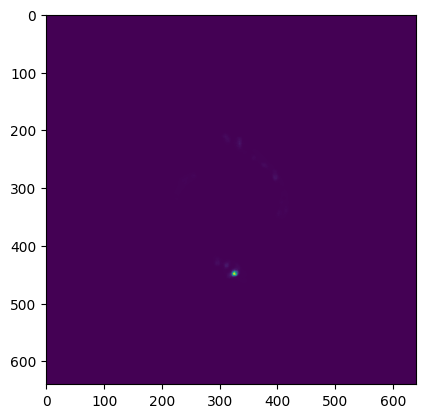

In [82]:
plt.imshow(predmaxxed[1].detach().numpy())

## Amplitude math

Amplitude of the perturber mass function.

In [31]:
A = 0.1 * -0.9 / (10**(-.9*10) - 10**(-.9*9))

In [34]:
A * (10**(-.9*10) - 10**(-.9*8)) / (-.9)

0.8943282347242802

Now for the more serious part: calculating Sheth-Tormen at these scales.